# Example for lipid flip-flop using segmentation
This document contains a worked example for calculating lipid flip-flop using segmentation data. By default the cholesterol will be tracked and plotted. In the end an example of plotting the total flips per frame is given, as well as the total up and down flips seperately.

## Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda

In [2]:
gro = '../eq_dry.gro'
xtc = '../md_dry.xtc'
segmentation_data = '../segmentation_new/clusters.npy'

## Loading the data
Ignore the errors MDA throws due to missing masses. It doesn't know what to do with the CG beads, but its fine as long as we do not use any mass related features.

In [3]:
u = mda.Universe(gro, xtc)

/home/bart/.virtualenvs/md/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/bart/.virtualenvs/md/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/bart/.virtualenvs/md/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: R
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [4]:
segmentation = np.load(segmentation_data)

## Helper classes
Here we neatly group some of the bookkeeping to keep our logic clean.

In [5]:
class Container():
    "A simple container class for our universe and segmentation data."
    def __init__(self, universe, segmentation):
        self.u = universe
        self.segmentation = segmentation
    
    def get_segment_from_resid(self, resid):
        """Returns the residue segment id in the current frame."""
        residue_index = self.u.residues[resid].atoms[0].ix
        current_frame = self.u.trajectory.frame
        residue_segment = self.segmentation[current_frame, residue_index] 
        return residue_segment
    
    def get_segments_from_selection(self, selection):
        """Returns an array of lipids segments for the given resname 
        in the current frame. The selection should adhere
        to the basic mda selection syntax."""
        selection = self.u.select_atoms(selection)
        resids = selection.residues.ix
        segments = [container.get_segment_from_resid(resid) 
                        for resid in resids]
        return np.asarray(segments, dtype=int)

## General approach for calculating the flip-flops
Here we show some useful syntax in tackling the problem. We need to be able to find the segment for our lipids of interestWe will do this for all the frames. Then we check which lipid segments have changed. Remember that not all lipids will always have a (relevant) segment assigned, which complicates things a little bit.

In [6]:
# Create our container
container = Container(u, segmentation)

In [7]:
# We explicitly state our leaflets and lipids of interest
leaflet1 = 1
leaflet2 = 2
residues = container.u.select_atoms('resname CHOL').residues

In [8]:
# Set the active frame to frame 0
container.u.trajectory[0]

< Timestep 0 with unit cell dimensions [98.5118   98.5118   96.185394 90.       90.       90.      ] >

In [9]:
# Preparing our segment per resid array
segments_per_frame = np.zeros((len(container.u.trajectory), 
                               len(residues)))
segments_per_frame.shape

(7327, 66)

In [44]:
# Obtain the resid segment for each frame
for idx, frame in enumerate(container.u.trajectory):
    segments_per_frame[idx] = container.get_segments_from_selection('resname CHOL')
    print(f'\rWorking on frame {idx+1}/{segments_per_frame.shape[0]}.             ', 
          end='')

Working on frame 7327/7327.             

In [45]:
print(segments_per_frame)

[[2. 2. 2. ... 1. 1. 1.]
 [2. 2. 2. ... 1. 1. 1.]
 [2. 2. 2. ... 1. 1. 1.]
 ...
 [2. 1. 2. ... 1. 2. 2.]
 [2. 1. 2. ... 1. 2. 2.]
 [2. 1. 2. ... 1. 2. 2.]]


In [46]:
# Create two faulty ones just for testing.
segments_per_frame[10, 12] = 0
segments_per_frame[10, 12] = 15
segments_per_frame[10, [12, 13]]

array([15.,  2.])

In [47]:
# To solve the problem of irrelevant assignment we replace out targets,
#  by doing so we make sure that a value of -1 and 1 reflect a flip. 
#  All other values are not relevant.
leaflet_mask1 = segments_per_frame==leaflet1
leaflet_mask2 = segments_per_frame==leaflet2
segments_per_frame[:] = 0
segments_per_frame[leaflet_mask1] = 1
segments_per_frame[leaflet_mask2] = 2
print(segments_per_frame)

[[2. 2. 2. ... 1. 1. 1.]
 [2. 2. 2. ... 1. 1. 1.]
 [2. 2. 2. ... 1. 1. 1.]
 ...
 [2. 1. 2. ... 1. 2. 2.]
 [2. 1. 2. ... 1. 2. 2.]
 [2. 1. 2. ... 1. 2. 2.]]


In [48]:
# Setting all values which are not relevant to their previous segment.
#  This is for loop and probably we can do this better, but 
#  for now it is at least clear what we are doing.
for idx, frame in enumerate(segments_per_frame):
    if idx == 0:
        continue
    else:
        # Find the indices of all the residues which 
        #  are not asigne to 0.
        bad_resids = np.where(frame == 0)[0]
        if bad_resids.size:
            print('There is a bad one!')
            # Set the value of a non set segment to the previous
            #  value.
            previous_frame = segments_per_frame[idx-1]
            frame[list(bad_resids)] = previous_frame[bad_resids]

There is a bad one!


In [49]:
# These values should now be the same.
print(segments_per_frame[ 9, [11, 12]])
print(segments_per_frame[10, [11, 12]])

[2. 2.]
[2. 2.]


In [50]:
# Calculating the flips by differentiating
flips = segments_per_frame[1:] - segments_per_frame[:-1]

## Plotting our simple flip-flop results

In [54]:
sums = [np.sum(np.abs(frame)) for frame in flips]

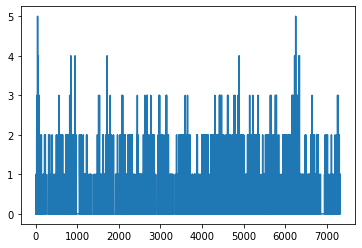

In [63]:
plt.plot(sums)
plt.show()

In [79]:
# Be careful, up and down is relative and this should be checked!
ups_and_downs = dict()
ups_and_downs['ups']   = []
ups_and_downs['downs'] = []
for row in flips:
    ups_and_downs['ups'].append(len(np.where(row == 1)[0]))
    ups_and_downs['downs'].append(-len(np.where(row == -1)[0]))

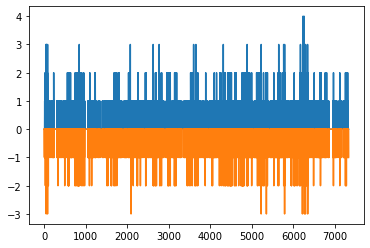

In [81]:
plt.plot(ups_and_downs['ups'])
plt.plot(ups_and_downs['downs'])
plt.show()